## Proyecto Final Logística 
---
<li>Luna Moreno</li>
<li>Carles Adam</li>
<li>Enrique Sayas</li>

## 0. Cargar Librerías

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## 1. Introducción

## 2. Modelo GRASP

### 2.1. Calibrar Alfa

In [3]:
data = pd.read_csv("resultados.csv", sep=";")
data

,archivo,alpha,valor,tiempo
0,MDG-a_10_100_m10,0.00,352.72,0.03
1,MDG-a_10_100_m10,0.05,348.59,0.03
2,MDG-a_10_100_m10,0.10,348.59,0.03
3,MDG-a_10_100_m10,0.15,345.24,0.03
4,MDG-a_10_100_m10,0.20,345.48,0.04
...,...,...,...,...
310,MDG-a_9_n500_m50,0.80,7706.28,4.30
311,MDG-a_9_n500_m50,0.85,7719.05,4.12
312,MDG-a_9_n500_m50,0.90,7693.47,3.98
313,MDG-a_9_n500_m50,0.95,7660.40,6.33


In [4]:
# Calcular el máximo y la desviación estándar
data["Maximo"] = float(0)
for archivo in data["archivo"].unique():
    data.loc[data["archivo"] == archivo,"Maximo"] = data[data["archivo"] == archivo]["valor"].values.max()
data["Dev"] = (data["Maximo"] - data["valor"]) / data["Maximo"]

In [5]:
# Seleccionar el mejor alfa
data.loc[:,["alpha","Dev"]].groupby("alpha").mean("Dev").sort_values("Dev").head()

,Dev
alpha,
0.85,0.007194
0.50,0.007598
0.10,0.008383
0.75,0.008573
0.45,0.008886


In [11]:
data["Color"] = ['Maximo' if x[1]["valor"] == x[1]["Maximo"] else "Otros" for x in data.iterrows()]
data.loc[data["alpha"] == 0.85, "Color"] = "alfa = 0.85"

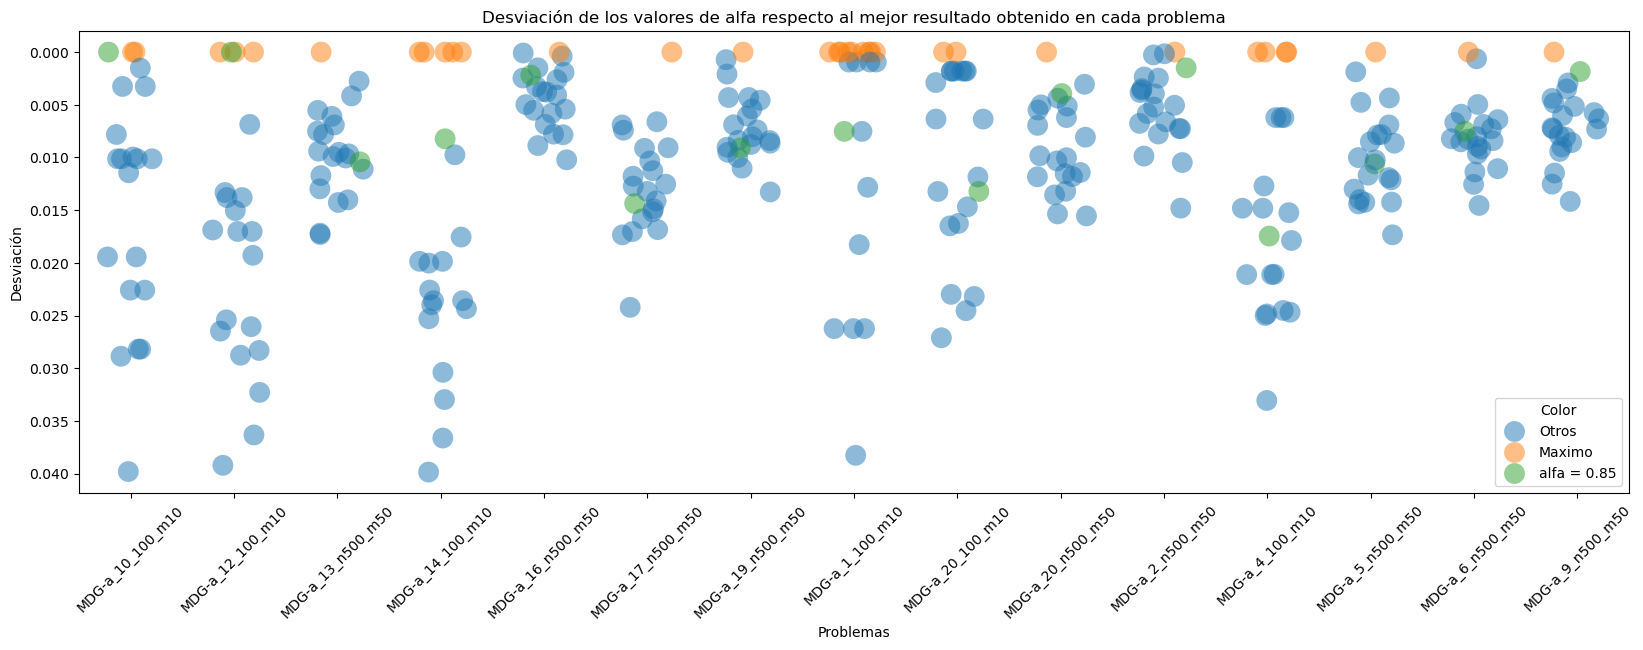

In [13]:
fig, ax = plt.subplots(figsize=(20,6))
sns.stripplot(data=data, x="archivo", y="Dev", hue="Color", alpha=.5, ax=ax, size=15, jitter=0.25)
ax.tick_params(axis='x', rotation=45)
ax.set_xlabel("Problemas")
ax.set_ylabel("Desviación")
ax.set_title("Desviación de los valores de alfa respecto al mejor resultado obtenido en cada problema")
ax.invert_yaxis()
plt.show()

## 3. Path Relinking

## 4. Comparación

## 5. Conclusiones

## 6. Bibliografía

Resende, M. G. C., Ribeiro, C. C., Glover, F., & Martí, R. (2010). Scatter search and path-relinking: Fundamentals, advances, and applications. En M. Gendreau & J.-Y. Potvin (Eds.), Handbook of Metaheuristics (pp. 87–107). Springer. https://doi.org/10.1007/978-1-4419-1665-5_4